In [70]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import datetime
from re import match
import random
import json
from time import strftime, gmtime
from functools import partial
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from typing import Dict, Union
from PIL import Image

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow import TensorFlowModel
from tqdm import tqdm
import numpy as np
import pandas as pd
from hydra import compose, initialize, core

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sys.path.append(os.path.dirname(os.getcwd()))
from src import custom_utils

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()

initialize(version_base='1.2', config_path='../src/config', job_name='dfw_notebook')
config = compose(config_name='main')
# Group configs
baseline_config = config['baseline']
fine_tune_config = config['fine_tune']

## SageMaker

In [3]:
sagemaker_session = sagemaker.Session(default_bucket=config.s3_bucket)
sagemaker_session

sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()

## Download DFW Data

In [5]:
s3_downloader = sagemaker.s3.S3Downloader()

# Take sample of 5000 images from the list of s3 paths
dfw_s3_paths = s3_downloader.list(config['dfw_s3_path'])
dfw_s3_paths = random.sample(dfw_s3_paths, 5000)

In [16]:
if not os.path.exists(local_path):
    os.mkdir(local_path)

download_func = partial(s3_downloader.download, local_path=local_path, sagemaker_session=sagemaker_session)

num_threads = multiprocessing.cpu_count()
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    executor.map(download_func, dfw_s3_paths)

In [7]:
# Check the number of images downloaded
local_image_paths = [os.path.join(local_path, file) for file in os.listdir(local_path)]
assert len(os.listdir(local_path)) == 5000

In [30]:
# Upload to s3
s3_uploader = sagemaker.s3.S3Uploader()

upload_func = partial(
    s3_uploader.upload, 
    sagemaker_session=sagemaker_session, 
    desired_s3_uri=f's3://{config["s3_bucket"]}/{config["s3_key"]}/dfw_data'
)

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    executor.map(upload_func, local_image_paths)

### Convert Image to Numpy Arrays

In [11]:
def load_image(image_path: str) -> Dict[str, Union[str, np.ndarray]]:
    """
    Load an image from a local path and return the image as a numpy array including the image path.

    Parameters
    ----------
    image_path : str
        The path to the image to load.
        
    Returns
    -------
    Dict[str, Union[str, np.ndarray]]
        A dictionary containing the image path and the image as a numpy array.
    """
    image = Image.open(image_path)
    image_resized = image.resize((256, 256)) 
    return {'image_path': image_path, 'image_array': np.expand_dims(np.array(image_resized), axis=0)}

In [12]:
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    images = list(executor.map(load_image, local_image_paths))

image_arrays = np.vstack([image_dict['image_array'] for image_dict in images]).astype(np.int16)
image_paths = [image_dict['image_path'] for image_dict in images]

## Deploy Best Classification Model

In [14]:
best_model = TensorFlowModel(
    model_data=config['best_model_s3_path'],
    role=role,
    framework_version=config['framework_version']
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type=baseline_config['instance_type'],
    endpoint_name=fine_tune_config.endpoint_name + '-' + strftime('%H-%M-%S', gmtime())
)

----!

Classify `dfw` images and subset for all kitchen images:

In [15]:
# Define the batch size
batch_size = 5

# Generate predictions in batches
num_instances = image_arrays.shape[0]
num_batches = (num_instances + batch_size - 1) // batch_size

batch_size, num_instances, num_batches

(5, 5000, 1000)

In [44]:
predicted_probs = []
for i in tqdm(range(num_batches)):

    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_instances)
    batch = image_arrays[start_idx:end_idx]
    
    # Call the predict method of the TensorFlowPredictor object
    predictions = predictor.predict(batch)
    
    # Append the predicted labels to the list
    predicted_probs.append(predictions['predictions'])

# Concatenate the predicted labels from all batches (down the rows)
predicted_probs = np.concatenate(predicted_probs, axis=0)

predicted_labels = np.argmax(predicted_probs, axis=1)

predicted_labels

100%|██████████| 1000/1000 [15:30<00:00,  1.07it/s]


array([2, 1, 2, ..., 2, 0, 6])

Find all indices of kitchens:

In [58]:
kitchen_int_label = config['class_label_map']['kitchen']

pos_indices = np.nonzero(predicted_labels == kitchen_int_label)

Get list of images predicted to be kitchens:

In [62]:
kitchens = np.array(image_paths)[pos_indices]

## Build List of Kitchen Images

Sample, verify, and build the list of images manually:

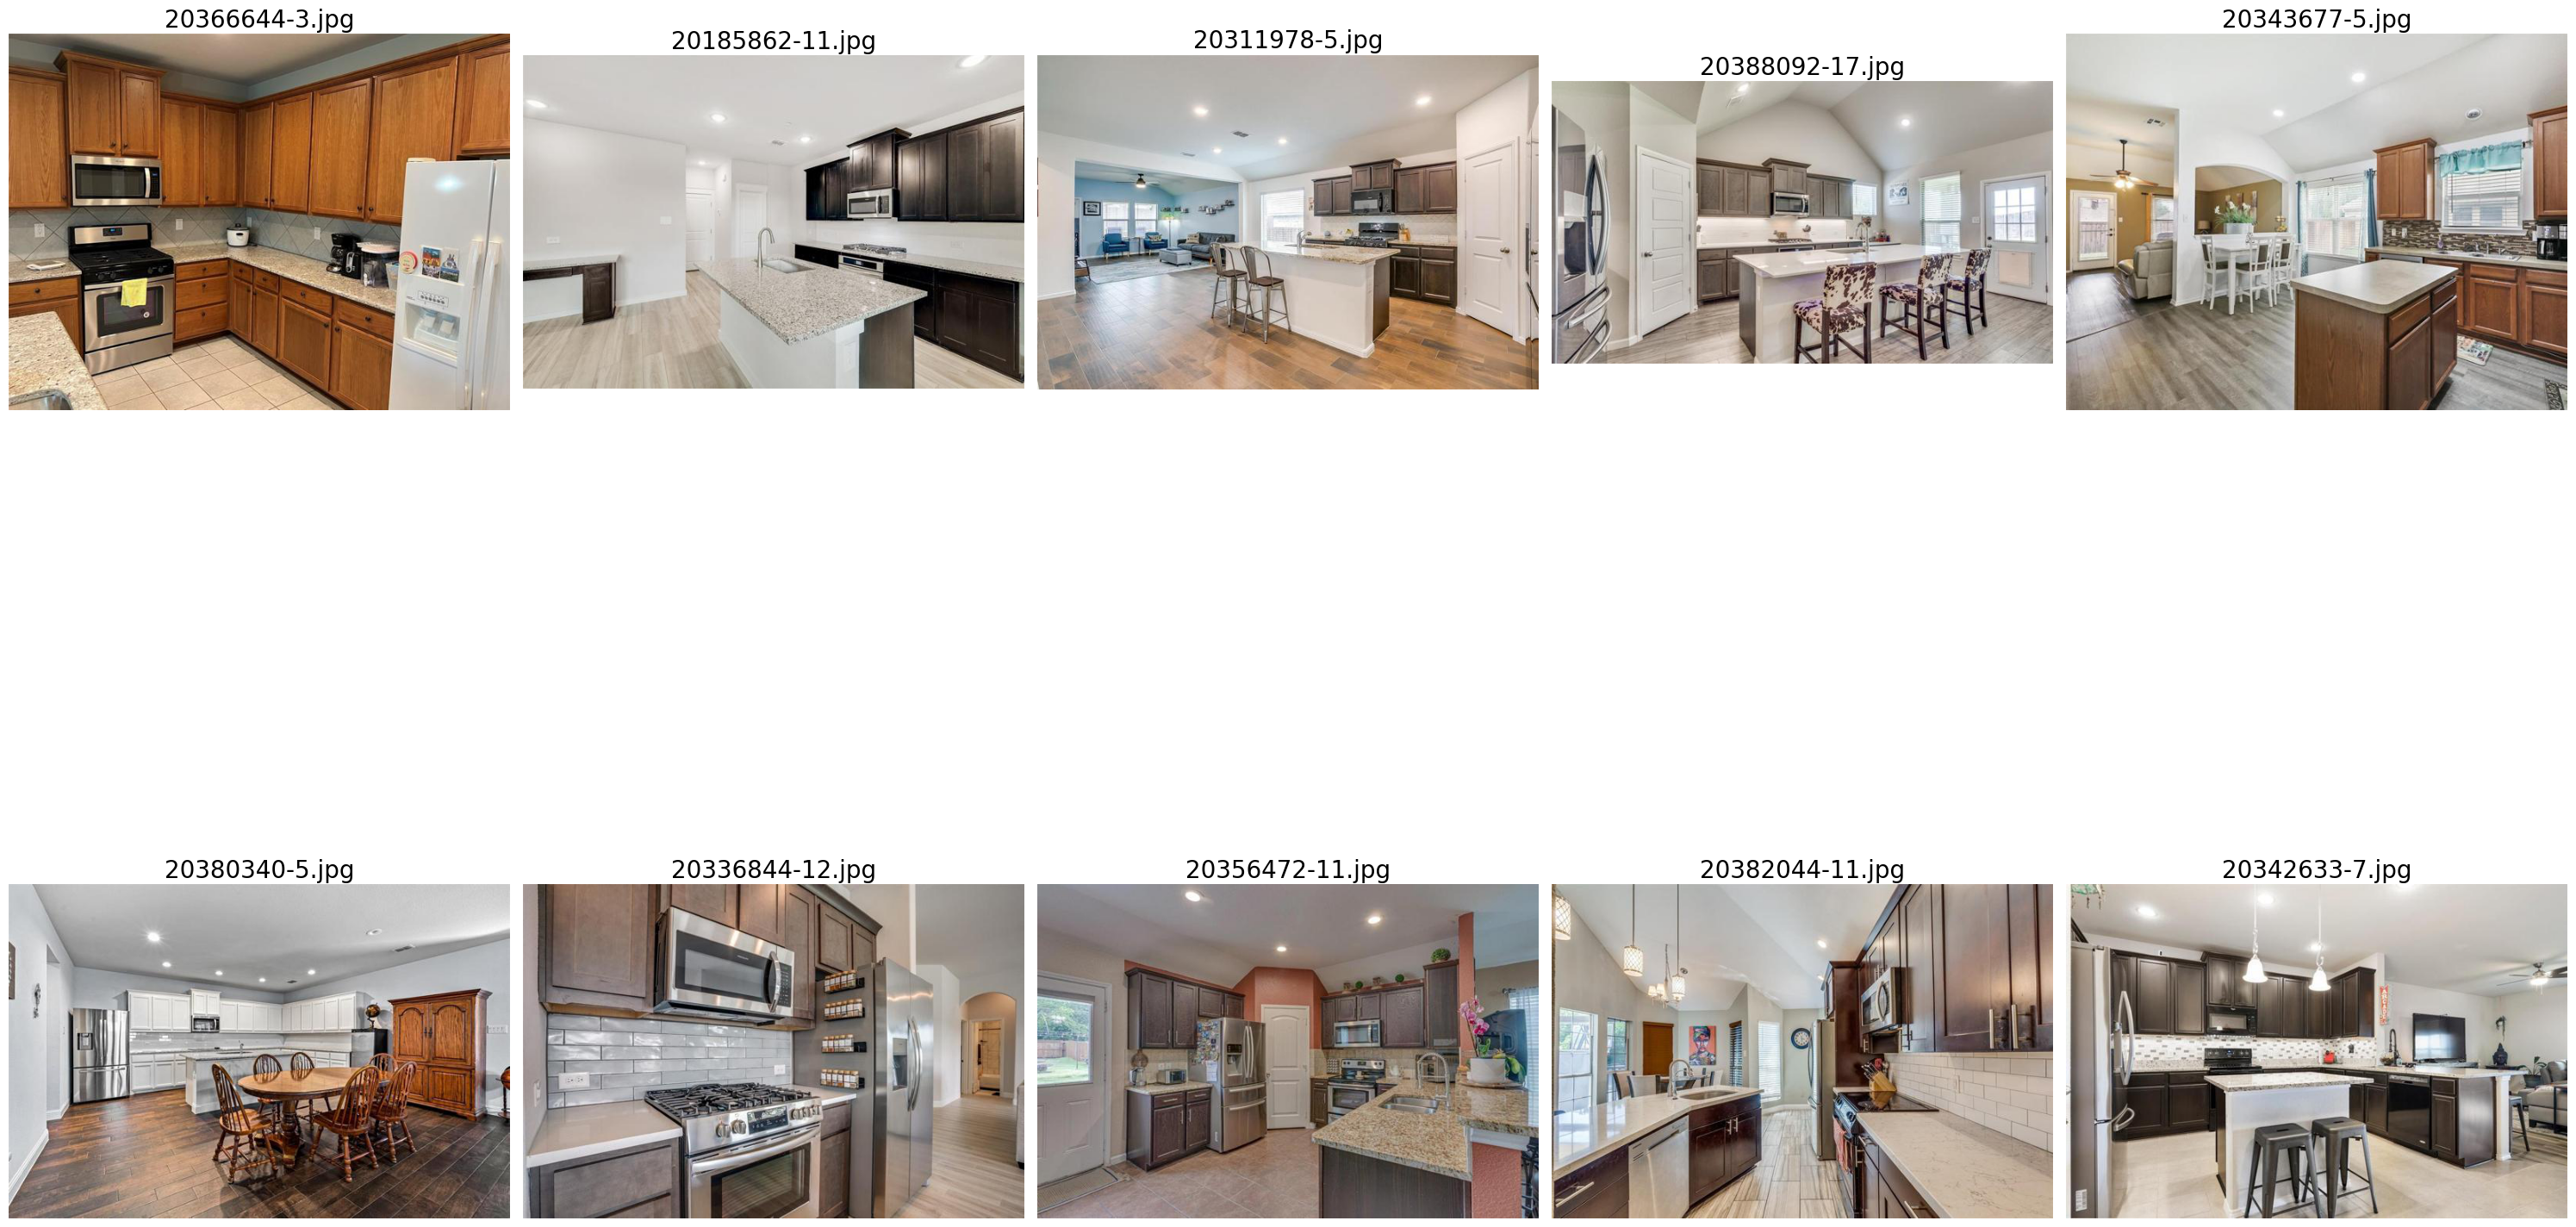

In [163]:
# Sample 10 images
selected_images = random.sample(kitchens.tolist(), 10)

fig, axes = plt.subplots(2, 5, figsize=(30, 25))

for i, img_path in enumerate(selected_images):
    img = mpimg.imread(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path), fontsize=20)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [95]:
kitchen_image_paths = []

If the images are correctly classified as kitchens, add the `selected_images` to the running list of image file paths. Rinse and repeat until getting the desired number of images:

In [164]:
selected_images

['/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20366644-3.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20185862-11.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20311978-5.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20388092-17.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20343677-5.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20380340-5.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20336844-12.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20356472-11.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20382044-11.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20342633-7.jpg']

In [165]:
correct_kitchens = [
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20366644-3.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20185862-11.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20311978-5.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20388092-17.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20343677-5.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20380340-5.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20336844-12.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20356472-11.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20382044-11.jpg',
 '/home/ec2-user/SageMaker/ds_sagemaker_scene_classification/notebooks/dfw_images/20342633-7.jpg'
]

In [166]:
for img_path in correct_kitchens:
    kitchen_image_paths.append(img_path)

# Remove duplicate images from the list
kitchen_image_paths = [*set(kitchen_image_paths)]

len(kitchen_image_paths)

124

Now, we upload the images from local to s3:

In [169]:
upload_func = partial(
    s3_uploader.upload, 
    sagemaker_session=sagemaker_session, 
    desired_s3_uri=f's3://{config["s3_bucket"]}/object-detection/dfw_kitchens'
)

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    executor.map(upload_func, kitchen_image_paths)

## Clean-Up

In [171]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': '0b9b7122-e493-47b9-bedb-2c0ffd5f0eaa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0b9b7122-e493-47b9-bedb-2c0ffd5f0eaa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 28 Jul 2023 23:31:36 GMT'},
  'RetryAttempts': 0}}

In [172]:
sm_boto3.close()